In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics.pairwise import linear_kernel
import nltk


In [2]:
# Cargo los datos de las películas\n",
df_movies = pd.read_csv("data/launch/movies.csv")
df_genres = pd.read_csv("data/launch/genres.csv")
df_movie_genres = pd.read_csv("data/launch/movie_genres.csv")

In [3]:
# Obtengo una lista de todos los títulos de las películas
titulos = df_movies["title"].fillna("").tolist()

# Concateno todos los títulos en una sola cadena de texto
texto = " ".join(titulos)

In [4]:
# Creo un objeto WordCloud con las configuraciones deseadas
wordcloud = WordCloud(width=800, height=400, max_words=100, background_color='black').generate(texto)

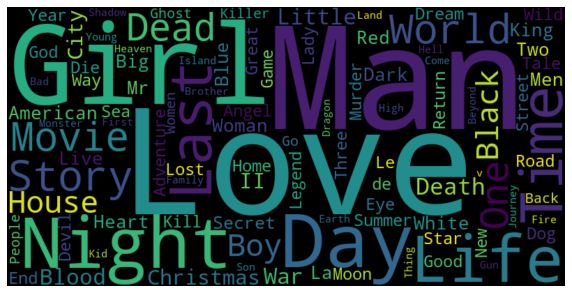

In [5]:
plt.figure(figsize=(10, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

In [6]:
df_movie_genres_2 = pd.merge(df_movie_genres, df_genres[['genre_id', 'name']], on='genre_id', how='left')
# Paso 1: Agrupar los géneros por id_movie y combinarlos en listas
grouped_genres = df_movie_genres_2.groupby('id')['name'].agg(' '.join).reset_index()
# Paso 2: Realizar el join entre df_movies y grouped_genres
df_movies = pd.merge(df_movies, grouped_genres, on='id', how='left')
# Rename column 'name' to 'gender_name'
df_movies = df_movies.rename(columns={'name': 'genres_name'})
# Change column type to string for column: 'genres_name'
df_movies = df_movies.astype({'genres_name': 'string'})
# Replace missing values with "No Gender" in column: 'genres_name'
df_movies = df_movies.fillna({'genres_name': "No Genre"})
# Replace all instances of "," with "" in column: 'overview'
df_movies['overview'] = df_movies['overview'].str.replace(",", "", case=False, regex=False)

In [7]:
df_movies.head()

,id,title,original_language,overview,tagline,status,runtime,release_date,release_year,budget,revenue,return,popularity,vote_average,vote_count,collection_id,has_collection,genres_name
0,2,Ariel,fi,Taisto Kasurinen is a Finnish coal miner whose...,NaN,Released,69,1988-10-21,1988,0.0,0.0,0.00,3.86,7.1,44,NaN,0,Drama Crime
1,3,Shadows in Paradise,fi,An episode in the life of Nikander a garbage m...,NaN,Released,76,1986-10-16,1986,0.0,0.0,0.00,2.29,7.1,35,NaN,0,Drama Comedy
2,5,Four Rooms,en,It's Ted the Bellhop's first night on the job....,Twelve outrageous guests. Four scandalous requ...,Released,98,1995-12-09,1995,4000000.0,4300000.0,1.08,9.03,6.5,539,NaN,0,Crime Comedy
3,6,Judgment Night,en,While racing to a boxing match Frank Mike John...,Don't move. Don't whisper. Don't even breathe.,Released,110,1993-10-15,1993,0.0,12136938.0,0.00,5.54,6.4,79,NaN,0,Action Thriller Crime
4,11,Star Wars,en,Princess Leia is captured and held hostage by ...,"A long time ago in a galaxy far, far away...",Released,121,1977-05-25,1977,11000000.0,775398007.0,70.49,42.15,8.1,6778,10.0,1,Adventure Action Science Fiction


In [8]:
df_movies = df_movies[['overview', 'popularity','title', "genres_name"]]

In [9]:
df_movies.head()

,overview,popularity,title,genres_name
0,Taisto Kasurinen is a Finnish coal miner whose...,3.86,Ariel,Drama Crime
1,An episode in the life of Nikander a garbage m...,2.29,Shadows in Paradise,Drama Comedy
2,It's Ted the Bellhop's first night on the job....,9.03,Four Rooms,Crime Comedy
3,While racing to a boxing match Frank Mike John...,5.54,Judgment Night,Action Thriller Crime
4,Princess Leia is captured and held hostage by ...,42.15,Star Wars,Adventure Action Science Fiction


In [10]:
df_ML = df_movies.copy()

In [11]:
df_ML.shape

(45349, 4)

In [12]:
df_ML.tail()

,overview,popularity,title,genres_name
45344,NaN,0.35,Thick Lashes of Lauri Mäntyvaara,Romance Comedy
45345,Manuel is a young boy who travels from long ag...,0.00,Manuel on the Island of Wonders,Fantasy Drama
45346,- Written by Ørnås,0.07,Midnight Man,No Genre
45347,Rune Balot goes to a casino connected to the ...,1.93,Mardock Scramble: The Third Exhaust,No Genre
45348,Avalanche Sharks tells the story of a bikini ...,2.19,Avalanche Sharks,No Genre


In [13]:
df_ML = df_ML.dropna().reset_index(drop=True)

In [14]:
df_ML.shape

(44408, 4)

In [15]:
df_ML=df_ML.head(15000)

In [16]:
def preprocess_text(text):
    return text.lower()

def calculate_cosine_similarity(matrix):
    return cosine_similarity(matrix)

def calculate_jaccard_similarity(genre_list1, genre_list2):
    intersection = len(set(genre_list1).intersection(genre_list2))
    union = len(set(genre_list1).union(genre_list2))
    return intersection / union if union != 0 else 0.0

def precompute_matrix(column, vectorizer):
    matrix = vectorizer.fit_transform(column)
    return matrix

def get_similar_movies(similarity_matrix, reference_index):
    similar_movies = list(enumerate(similarity_matrix[reference_index]))
    similar_movies = sorted(similar_movies, key=lambda x: x[1], reverse=True)
    return similar_movies

def get_top_popular_movies(df_ML):
    df_ML_sorted = df_ML.sort_values(by='popularity', ascending=False)
    top_popular_movies = df_ML_sorted.iloc[:5]
    return top_popular_movies

def recommend_movies(title, df_ML, title_to_index):
    movie_index = title_to_index.get(title)
    if movie_index is None:
        return ["No se encontró la película en la base de datos."]
    
    similar_movies_title = get_similar_movies(titulo_similarity, movie_index)
    similar_movies_genre = [(i, calculate_jaccard_similarity(df_ML['genres_clean'][movie_index], row['genres_clean']))
                            for i, row in df_ML.iterrows()]
    similar_movies_description = get_similar_movies(descripcion_similarity, movie_index)
    
    all_similarities = [(idx, (sim_title + sim_genre + sim_description) / 3.0)
                        for (idx, sim_title), (_, sim_genre), (_, sim_description)
                        in zip(similar_movies_title, similar_movies_genre, similar_movies_description)]
    all_similarities = sorted(all_similarities, key=lambda x: x[1], reverse=True)
    
    recommended_movies = []
    for idx, _ in all_similarities:
        if idx != movie_index and len(recommended_movies) < 5:
            recommended_movies.append(df_ML.iloc[idx]['title'])
    
    return recommended_movies

# Cargar los datos y realizar preprocesamiento
#df_ML = pd.read_csv("data/launch/movies.csv")
df_ML['title_clean'] = df_ML['title'].apply(preprocess_text)
df_ML['genres_clean'] = df_ML['genres_name'].apply(lambda x: [genre.lower() for genre in x.split()])
df_ML['overview_clean'] = df_ML['overview'].apply(preprocess_text)

# Preparar matrices y cálculos de similitud
count_vectorizer = CountVectorizer(stop_words=nltk.corpus.stopwords.words('english'))
titulo_matrix = precompute_matrix(df_ML['title_clean'], count_vectorizer)
titulo_similarity = calculate_cosine_similarity(titulo_matrix)

descripcion_vectorizer = TfidfVectorizer(stop_words=nltk.corpus.stopwords.words('english'))
descripcion_matrix = precompute_matrix(df_ML['overview_clean'], descripcion_vectorizer)
descripcion_similarity = calculate_cosine_similarity(descripcion_matrix)

# Crear diccionario de indexación por título
title_to_index = {title: idx for idx, title in enumerate(df_ML['title'])}

In [17]:
recommended_movies = recommend_movies('Ariel', df_ML, title_to_index)
recommended_movies

['Open Hearts',
 'Star Trek: Nemesis',
 'Man of Iron',
 "Boys Don't Cry",
 'The Cabinet of Dr. Caligari']

In [ ]:
# Crear un DataFrame vacío para almacenar los resultados
result_df = pd.DataFrame(columns=['movie_title', 'recommended_titles'])

# Recorrer cada título en el DataFrame
for title in df_ML['title']:
    recommended_movies = recommend_movies(title, df_ML, title_to_index)
    recommended_movies_str = ', '.join(recommended_movies)
    
    result_df = result_df.append({'movie_title': title, 'recommended_titles': recommended_movies_str}, ignore_index=True)

# Guardar el DataFrame en un archivo CSV
result_df.to_csv("recomendaciones_peliculas.csv", index=False)

In [19]:
result_df.to_csv("recomendaciones_peliculas.csv", index=False)

In [53]:
def precompute_recommendations(df_ML):
    title_to_index = {title: idx for idx, title in enumerate(df_ML['title'])}
    recommended_movies = []

    for idx, row in df_ML.iterrows():
        movie_title = row['title']

        # Matrices precalculadas
        count_vectorizer = CountVectorizer()
        titulo_matrix = count_vectorizer.fit_transform(df_ML['title_clean'])
        titulo_similarity = cosine_similarity(titulo_matrix)
        similar_movies_title = list(enumerate(titulo_similarity[idx]))

        # Coincidencia de Género
        def jaccard_similarity(genre_list1, genre_list2):
            intersection = len(set(genre_list1).intersection(genre_list2))
            union = len(set(genre_list1).union(genre_list2))
            return intersection / union if union != 0 else 0.0

        similar_movies_genre = []
        for i, row in df_ML.iterrows():
            similarity = jaccard_similarity(df_ML['genres_clean'][idx], row['genres_clean'])
            similar_movies_genre.append((i, similarity))

        # Coincidencia de Descripción
        tfidf_vectorizer = TfidfVectorizer()
        descripcion_matrix = tfidf_vectorizer.fit_transform(df_ML['overview_clean'])
        descripcion_similarity = cosine_similarity(descripcion_matrix)
        similar_movies_description = list(enumerate(descripcion_similarity[idx]))

        # Combinar y ordenar recomendaciones
        all_similarities = [(idx, (sim_title + sim_genre + sim_description) / 3.0)
                            for (idx, sim_title), (_, sim_genre), (_, sim_description)
                            in zip(similar_movies_title, similar_movies_genre, similar_movies_description)]
        all_similarities = sorted(all_similarities, key=lambda x: x[1], reverse=True)

        recommended_titles = []
        for movie_idx, _ in all_similarities:
            if movie_idx != idx and len(recommended_titles) < 5:
                recommended_titles.append(df_ML.iloc[movie_idx]['title'])

        recommended_movies.append({
            'movie_title': movie_title,
            'recommended_titles': ', '.join(recommended_titles)
        })

    recommended_df = pd.DataFrame(recommended_movies)
    return recommended_df

precomputed_recommendations = precompute_recommendations(df_ML)

# Guardar el DataFrame precomputado en un archivo CSV
precomputed_recommendations.to_csv('data/ML/precomputed_recommendations.csv', index=False)

In [8]:
def get_recommendations_for_title(title):
    # Cargar el DataFrame precalculado desde el archivo CSV
    preview_recommendations = pd.read_csv("data/ML/recomendaciones_peliculas.csv")

    recommendations = preview_recommendations[preview_recommendations['movie_title'] == title]
    if not recommendations.empty:
        recommended_titles = recommendations.iloc[0]['recommended_titles']
        return recommended_titles.split(', ')
    else:
        return ["Película no encontrada en la Base de Datos."]

In [9]:
# Ejemplo de uso
title_to_search = 'Toy Story'
recommended_titles = get_recommendations_for_title(title_to_search)
recommended_titles

['Toy Story 2', 'Toy Story 3', 'Brave Story', 'The Toy', 'Batman Returns']